<a href="https://colab.research.google.com/github/caoTayTang/ML251/blob/main/1_spaceship_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spaceship Titanic - Predictive Modeling
**Nhóm**: ML4U

**Ngày**: 09/09/2025

**Môn học**: CO3117

**GVHD**: TS. Lê Thành Sách

**Github**: https://github.com/caoTayTang/ML251

**Landing page**: https://caotaytang.github.io/ML-251/

---

## 📖 Tổng quan Dự án

Notebook này ghi lại toàn bộ quy trình xây dựng và đánh giá các mô hình dự đoán cho Bài tập lớn 1 - Học máy với dữ liệu dạng bảng của môn học CO3117 tại Trường Đại học Bách Khoa TP HCM. Mục tiêu chính là dự đoán xem một hành khách có được dịch chuyển đến một chiều không gian khác trong một sự cố không-thời gian hay không.

Chúng tôi sẽ thực hiện dự án này qua ba giai đoạn chính:
1.  **Phân tích Dữ liệu Khám phá (EDA):** Để hiểu sâu về dữ liệu, khám phá các mẫu và xác định mối quan hệ giữa các đặc trưng (features) và biến mục tiêu (target).
2.  **Pipeline Học máy Truyền thống:** Để xây dựng, huấn luyện và đánh giá một số mô hình ML cổ điển (ví dụ: Hồi quy Logistic, Random Forest).
3.  **Pipeline Học sâu:** Để xây dựng và đánh giá một mạng nơ-ron (MLP) nhằm xem xét liệu phương pháp học sâu có mang lại lợi ích về hiệu năng trên bộ dữ liệu dạng bảng này hay không.

**Thước đo Đánh giá:** Chỉ số chính để so sánh các mô hình sẽ là *Accuracy*

---



## ☰ Mục lục


## 1. ⚙️ Thiết lập Môi trường

Trong phần này, chúng ta sẽ nhập tất cả các thư viện cần thiết, định nghĩa các hằng số và tải tập dữ liệu.

### 1.1. Nhập các thư viện cần thiết


In [ ]:
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
!pip install tabpfn pytorch-tabnet

In [2]:
# Xử lý dữ liệu & Đại số tuyến tính
import pandas as pd
import numpy as np

# Trực quan hóa dữ liệu
import matplotlib.pyplot as plt
import seaborn as sns

# Học máy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.decomposition import PCA

# Học sâu
import torch
from tabpfn import TabPFNClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

# Đánh giá
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Util
import logging
import warnings
import sys
import os
import random



### 1.2. Cấu hình và các hàm hỗ trợ

In [3]:
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("viridis")


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

### 1.3. Tải dữ liệu

In [4]:
!git clone https://github.com/caoTayTang/ML251

Cloning into 'ML251'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 393 (delta 21), reused 30 (delta 11), pack-reused 346 (from 1)
Receiving objects: 100% (393/393), 90.80 MiB | 18.53 MiB/s, done.
Resolving deltas: 100% (262/262), done.
Updating files: 100% (24/24), done.


In [5]:
from ML251.modules.eda_fn import get_missings_percentage
from ML251.modules.configurator import *
from ML251.modules.analyzer import create_professional_analysis

In [6]:
train_path = "ML251/data/spaceship-titanic/train.csv"
train_df = pd.read_csv(train_path)

print("Dữ liệu Huấn luyện:")
display(train_df.head())

Dữ liệu Huấn luyện:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## 2. 📊 Khám phá và tiền xử lý dữ liệu (EDA)
Tại đây, chúng ta sẽ phân tích sâu bộ dữ liệu để hiểu cấu trúc, sự phân phối và các mẫu ẩn bên trong.



### 2.1. Tổng quan ban đầu về dữ liệu

In [7]:
print(f"Kích thước dữ liệu huấn luyện: {train_df.shape}")

Kích thước dữ liệu huấn luyện: (8693, 14)


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [9]:
# Thống kê mô tả các biến numerical
display(train_df.describe())

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [10]:
# Thống kê mô tả các biến phân loại
display(train_df.describe(include = "object"))

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,9280_02,Earth,False,G/734/S,TRAPPIST-1e,False,Ankalik Nateansive
freq,1,4602,5439,8,5915,8291,2


In [11]:
print(f"Số dòng bị trùng lặp: {train_df.duplicated().sum()}")

Số dòng bị trùng lặp: 0


In [12]:
# Kiểm tra missing values
get_missings_percentage(train_df, train_df.columns)

,%Missing
PassengerId,0.0%
HomePlanet,0.02%
CryoSleep,0.02%
Cabin,0.02%
Destination,0.02%
Age,0.02%
VIP,0.02%
RoomService,0.02%
FoodCourt,0.02%
ShoppingMall,0.02%


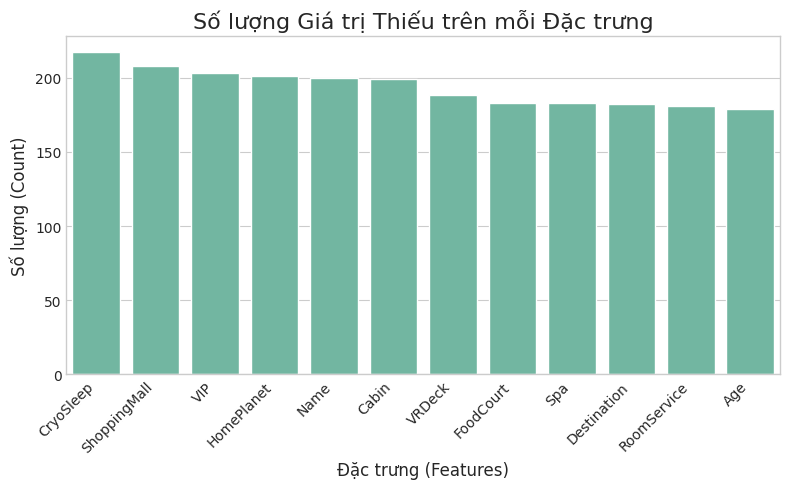

In [13]:
missing_counts = train_df.isnull().sum()

# Lọc ra những cột có giá trị thiếu
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
sns.barplot(x=missing_counts.index, y=missing_counts.values)

plt.title('Số lượng Giá trị Thiếu trên mỗi Đặc trưng', fontsize=16)
plt.xlabel('Đặc trưng (Features)', fontsize=12)
plt.ylabel('Số lượng (Count)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

> 📝 **Nhận xét:**  
> Bộ dữ liệu có **8693 mẫu**, với **12 đặc trưng** và **1 biến mục tiêu**  
> - 6 đặc trưng dạng số  
> - 6 đặc trưng dạng object (categorical)  
> - Các thuộc tính đều có missing value  
> - Không có mẫu trùng lặp

### 2.2. Phân tích đơn biến
Vì thuộc tính `Name` và `Cabin` có giá trị phân biệt gần bằng số luợng mẫu của tập dữ liệu (Xem thống kê mô tả ở `3. Tổng quan dữ liệu`). Nên không có nhiều ý nghĩa thống kê để phân tích ở đây.

#### 2.2.1. Phân phối dữ liệu

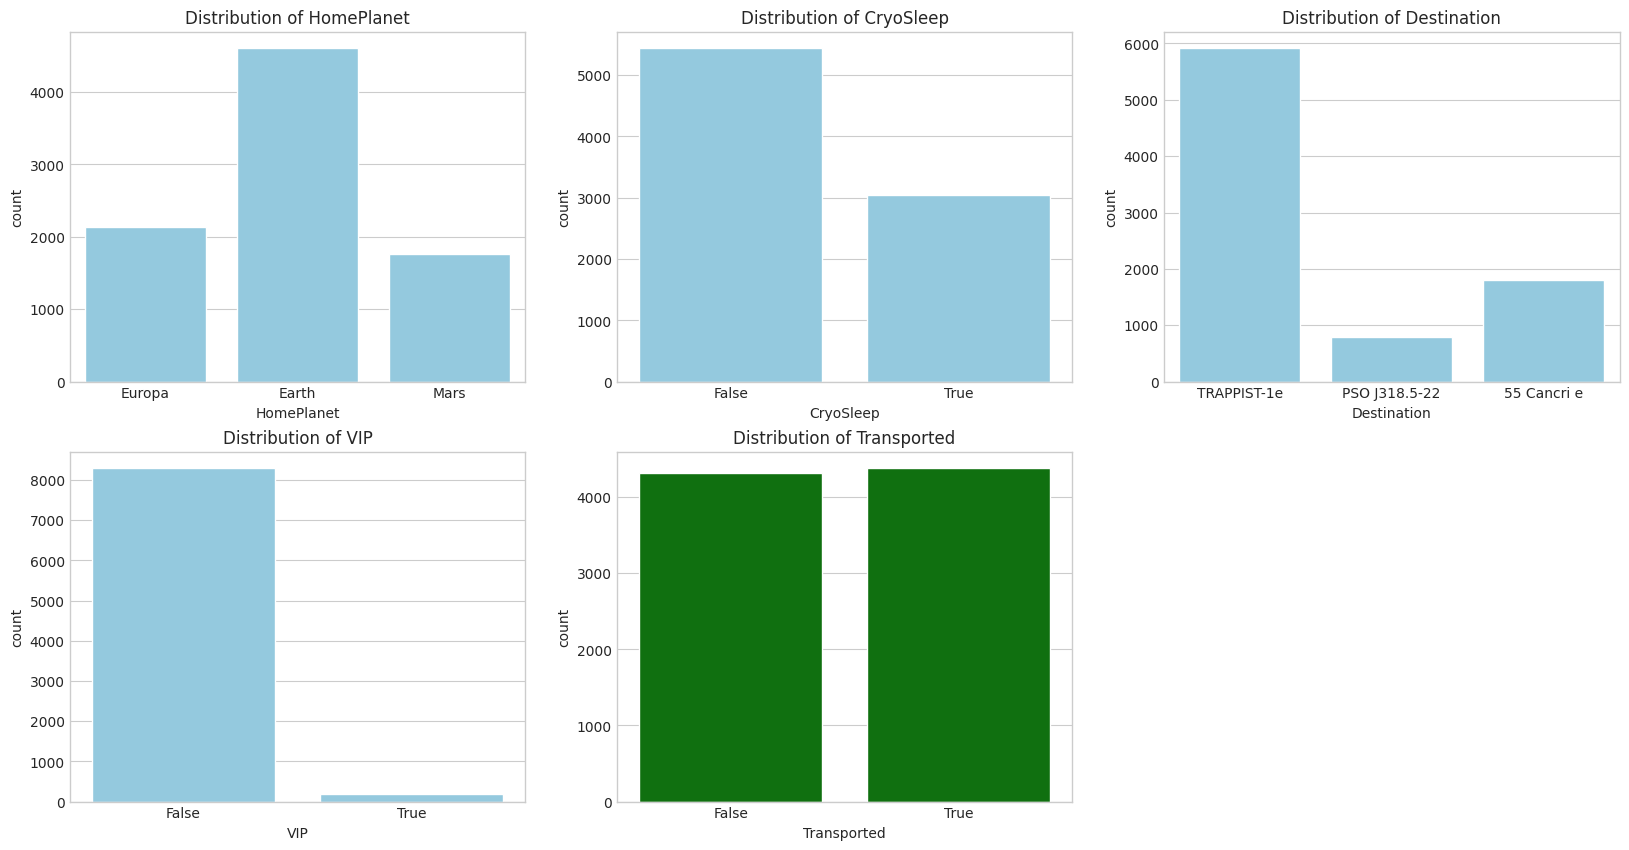

In [14]:
# Biểu đồ phân phối các biến phân loại
categorical_interests = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Transported']
fig, axis = plt.subplots(2, 3, figsize=(20, 10))
for i, col in enumerate(categorical_interests):
    color = "green" if col == "Transported" else "skyblue"
    ax = axis[i // 3, i % 3]
    sns.countplot(data=train_df, x=col, ax=ax, color=color)
    ax.set_title(f"Distribution of {col}")
fig.delaxes(axis[1, 2])

> 📝 **Nhận xét:**  
> - `HomePlanet`:
>   - `Earth`: chiếm đa số (khoảng 4500 người)
>   - `Europa`: đứng thử hai (khoảng 2100 người)
>   - `Mars`: khoảng 1800 người.\
>   -> **Hành khách đến chủ yếu từ Earth.**
> -  `CryoSleep`: Hành khách chọn ngủ đông ít hơn hành khách không chọn ngủ đông (gần một nửa)
> -  `Destination`: TRAPPIST-1e là điểm đến phổ biến nhất (khoảng 6000).
> -  `VIP`: Phần lớn hành khách không phải VIP, hành khách đăng kí VIP cực kỳ ít.
> -  `Transported`: Tỉ lệ nhãn ở biến mục tiêu gần như cân bằng, với khoảng 50.3% hành khách bị dịch chuyển

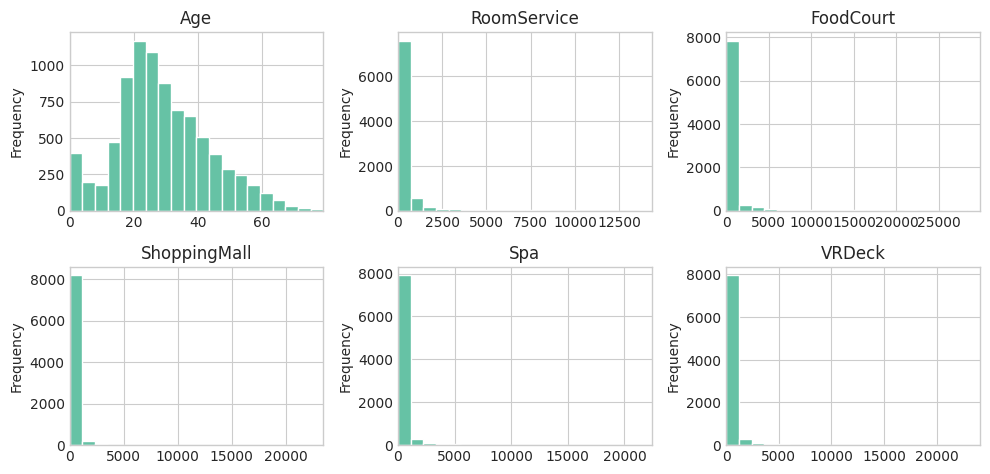

In [15]:
# Biểu đồ phân phối cho các biến số
numerical_features = train_df.select_dtypes(include=['float64']).columns
plt.figure(figsize=(10,7))
for i,col in enumerate(numerical_features):
    plt.subplot(3,3,i + 1)
    train_df[col].plot(kind='hist', bins=20)
    plt.xlim(0, train_df[col].max())
    plt.title(col)
plt.tight_layout()

> 📊 **Nhận xét**  
>
> - **Age**  
>   - Phân phối lệch trái  
>   - Đỉnh nằm ở nhóm từ 20 - 30 tuổi, đa phần là người trẻ  
>
> - **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**  
>   - Đa số giá trị bằng 0, phân phối lệch trái nặng  
>   - Có nhiều giá trị ngoại lai, nhiều nhất là ở `RoomService` và `FoodCourt`  
>   - **Hầu hết các hành khách không sử dụng dịch vụ của Spaceship Titanic**


#### 2.2.2. Ngoại lai

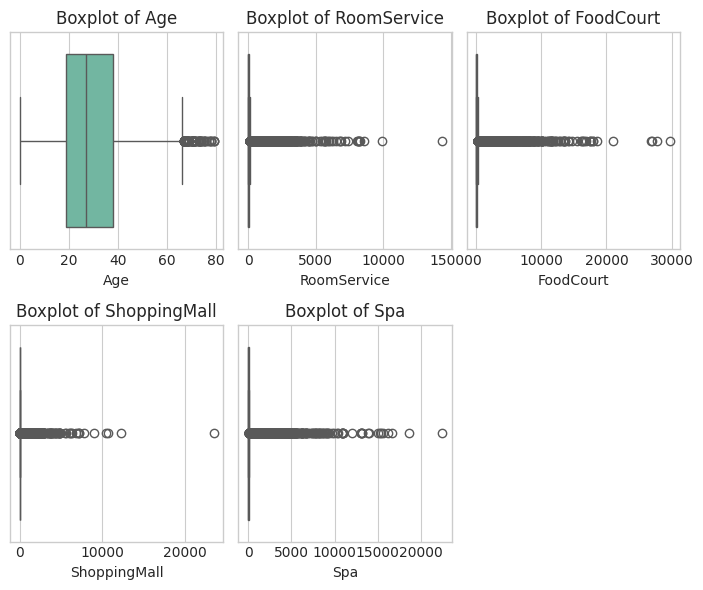

In [16]:
fig, axis = plt.subplots(2, 3, figsize=(7, 6))
for i, col in enumerate(numerical_features):
    ax = axis[i // 3, i % 3]
    sns.boxplot(x=train_df[col], ax=ax)
    ax.set_title(f"Boxplot of {col}")
fig.delaxes(axis[1, 2])
plt.tight_layout()

> 📝 **Nhận xét:**  
> - Như đã phân tích ở phần `2.2.1. Phân phối dữ liệu`. Các thuộc tính `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa` và `VRDeck` có nhiều giá trị ngoại lai, và điều đó thể hiện rõ ở các biểu đồ trên.
> - `Age`: cũng có vài giá trị ngoại lai.

### 2.3. Phân tích đa biến

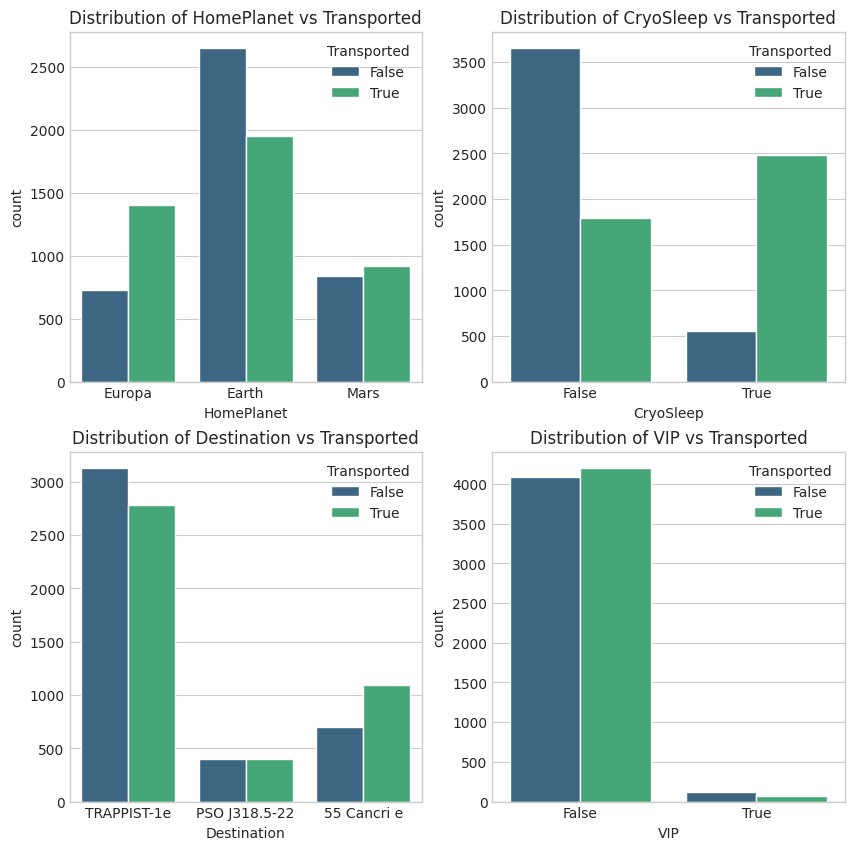

In [17]:
fig, axis = plt.subplots(2, 2, figsize=(10, 10))
categorical_multi = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
for i, col in enumerate(categorical_multi):
    ax = axis[i // 2, i % 2]
    sns.countplot(data=train_df, x=col, ax=ax, hue="Transported", palette="viridis")
    ax.set_title(f"Distribution of {col} vs Transported")

> 📊 **Nhận xét**  
>
> - **HomePlanet**  
>   - `Europa`: có tỷ lệ người bị *Transported* cao  
>   - `Earth`: số người không bị *Transported* cao  
>   - `Mars`: gần như cân bằng  
>
> - **CryoSleep**  
>   - Nhóm `CryoSleep = True`: phần lớn bị *Transported*  
>   - Nhóm `CryoSleep = False`: phần lớn không bị *Transported*  
>
> - **Destination** và **VIP**  
>   - Dữ liệu gần như cân bằng cả hai nhóm  
>   - Ngoại lệ: `Destination = "55 Cancri e"`, nhóm này có số lượng *Transported* cao hơn rõ rệt  


<Axes: xlabel='Transported', ylabel='Age'>

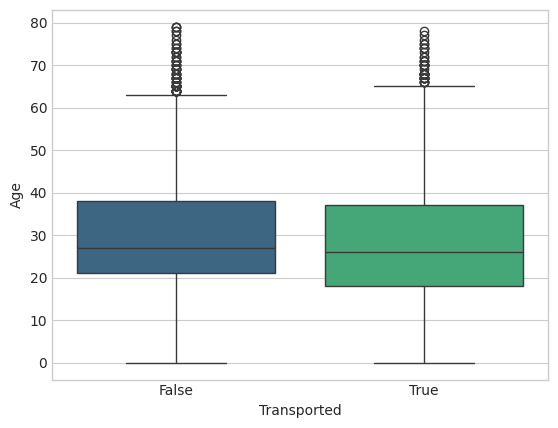

In [18]:
sns.boxplot(data = train_df, x=train_df["Transported"], y=train_df["Age"], palette="viridis")

> 📊 **Nhận xét**  
>
> - Hai nhóm *Transported* và *không Transported* có phân phối gần giống nhau.  
> - **Tuổi không phải là biến phân tách mạnh cho *Transported***.


<Axes: >

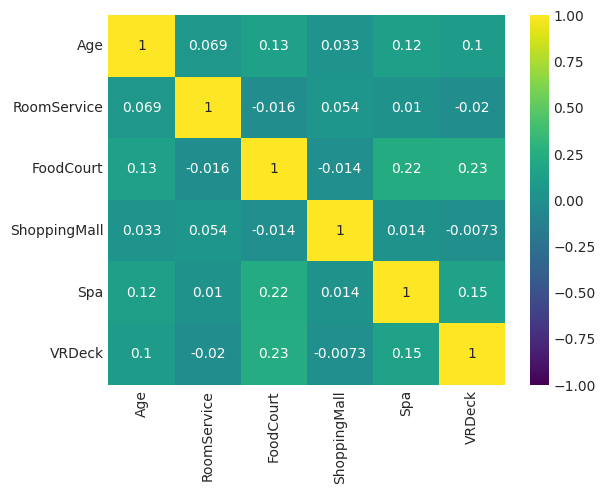

In [19]:
sns.heatmap(train_df.corr(numeric_only=True).iloc[:-1, :-1], annot=True, cmap='viridis', vmin=-1, vmax=1)

> 📊 **Nhận xét**  
> - Các biến số (`Age`, `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa` và `VRDeck`) không có quan hệ tuyến tính mạnh với nhau.
> - Điều này cho thấy rằng không có vấn đề đa cộng tuyến (multicollinearity) trên các thuộc tính dạng số.

### 2.4. Tiền xử lý dữ liệu

Sau khi đã khám phá dữ liệu, bước tiếp theo và quan trọng nhất là chuẩn bị và biến đổi dữ liệu thô thành một định dạng "sạch" và có cấu trúc mà các mô hình học máy có thể hiểu được. Quá trình này bao gồm ba giai đoạn chính:
1.  **Feature Engineering:** Tạo ra các đặc trưng mới, có ý nghĩa hơn từ các cột hiện có.
2.  **Xây dựng Pipeline tiền xử lý:** Thiết lập các quy trình tự động để xử lý giá trị thiếu, mã hóa và co giãn dữ liệu.
3.  **Phân chia Dữ liệu:** Chia dữ liệu thành các tập huấn luyện/kiểm tra và áp dụng các pipeline đã xây dựng.


#### 2.4.1. Feature Engineer

In [20]:
# Split <PassengerID> into <Group> and <Member>
train_df[["Group", "Member"]] = train_df["PassengerId"].str.split("_", expand=True)

# Split <Cabin> into <Deck>, <Num> and <Side> features
train_df[["Deck", "Num", "Side"]] = train_df["Cabin"].str.split("/", expand=True)

# Convert <Num>, <Group> to numeric type
train_df["Group"] = train_df["Group"].astype("float")
train_df["Num"] = train_df["Num"].astype("float")

# Eliminate unvaluable and redundant attribute: <Name>, <Cabin>, <PassengerId>
train_df = train_df.drop(columns=["Name", "Cabin", "PassengerId"])

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Group         8693 non-null   float64
 12  Member        8693 non-null   object 
 13  Deck          8494 non-null   object 
 14  Num           8494 non-null   float64
 15  Side          8494 non-null   object 
dtypes: bool(1), float64(8), object(7)
memory usage: 1.0+ MB


✍️ Giải thích:
- `PassengerId`: Được tách thành `Group` và `Member`. Đặc trưng Group có thể rất quan trọng, vì các thành viên trong cùng một nhóm (có thể là gia đình) nhiều khả năng sẽ có cùng kết quả dịch chuyển.
- `Cabin`: Được tách thành `Deck`, `Num`, và `Side`. Các đặc trưng này cung cấp thông tin vị trí không gian của hành khách trên tàu, đây là một yếu tố dự báo tiềm năng.
- Loại bỏ cột: Các cột gốc như `Name`, `Cabin`, `PassengerId` được loại bỏ vì thông tin của chúng đã được trích xuất hoặc chúng không có giá trị dự đoán cao.

#### 2.4.2. Xây dựng Pipeline tiền xử lý

Xây dựng hai pipeline riêng biệt để tối ưu hóa hiệu năng cho từng loại mô hình.
- Pipeline cho XGBoost: Tận dụng khả năng xử lý giá trị thiếu sẵn có của thuật toán.
- Pipeline cho các mô hình khác: Bao gồm các bước điền giá trị thiếu (imputation) tiêu chuẩn.

#### 2.4.3. Phân chia Dữ liệu

In [22]:
# # Split dataset to train/test = 0.8/0.2
X = train_df.drop("Transported", axis=1)
y = train_df["Transported"].astype("int")

# for col in categorical_features:
#     if col in X.columns:
#         X[col] = X[col].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### 2.5. Insight và Tổng kết EDA

> 📌 **Nhận xét:**
>
> - `CryoSleep`, `Destination`, `HomePlanet`: có mối liên hệ rõ với khả năng **Transported**, nên được ưu tiên làm đặc trưng.  
> - `Age`: tác động yếu đến khả năng **Transported**.  
> - Các biến chi tiêu: phân phối lệch, nhiều giá trị ngoại lệ → cần xử lý và có thể tạo thêm đặc trưng.  
> - `VIP`: dữ liệu mất cân bằng giữa các nhóm → khả năng ảnh hưởng hạn chế.  
> - Biến mục tiêu: phân bố cân bằng → thuận lợi cho huấn luyện mô hình phân loại.  


> 📌 **Kết quả sau tiền xử lý:**  
>
> - **Feature Engineering:** Đã trích xuất thành công các đặc trưng vị trí (*Deck*, *Side*) và nhóm (*Group*), đồng thời loại bỏ các cột không cần thiết.  
> - **Xử lý linh hoạt:** Sử dụng 2 pipeline riêng biệt, giúp tối ưu dữ liệu đầu vào cho từng loại thuật toán, đặc biệt khai thác tốt khả năng xử lý giá trị thiếu của **XGBoost**.  
> - **Dữ liệu sẵn sàng:** Hai bộ dữ liệu “sạch”, đã được mã hóa và chuẩn hóa, sẵn sàng cho việc huấn luyện và đánh giá:  
>   - `X_train` / `X_test`: dùng cho các mô hình chuẩn.  
>   - `X_train_xgb` / `X_test_xgb`: dùng riêng cho **XGBoost**.  


## 3. 🤖 Thí nghiệm

### 3.1. Giới thiệu mô hình

### **TabPFN (Tabular Prior-Data Fitted Networks)**

TabPFN là một mô hình **few-shot tabular learning** được đề xuất trong paper:

- Aaron Müller et al., *"Transformers Can Do Bayesian Inference,"* NeurIPS 2022.

#### Ý tưởng chính
- Huấn luyện một **transformer** trên hàng tỷ bài toán phân loại giả lập (synthetic classification tasks).
- Khi inference, chỉ cần **một forward pass** để dự đoán phân phối posterior → thay thế cho quá trình huấn luyện truyền thống.
- Không cần tuning nhiều, phù hợp cho dữ liệu nhỏ và vừa.

#### Minh họa

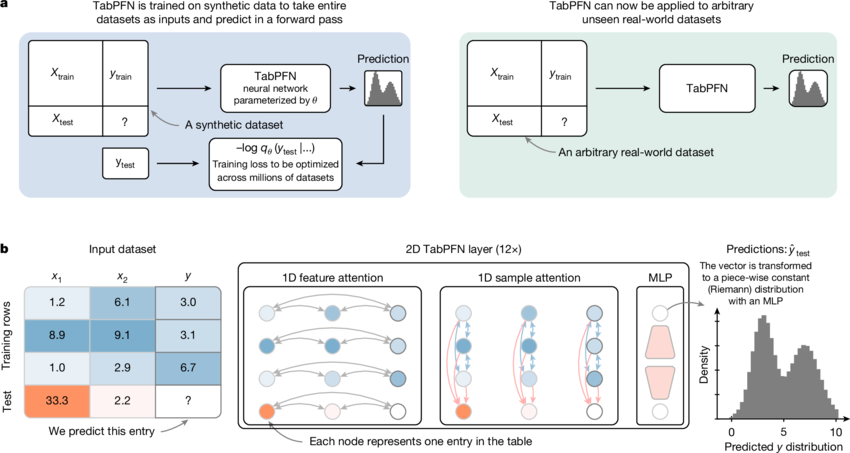

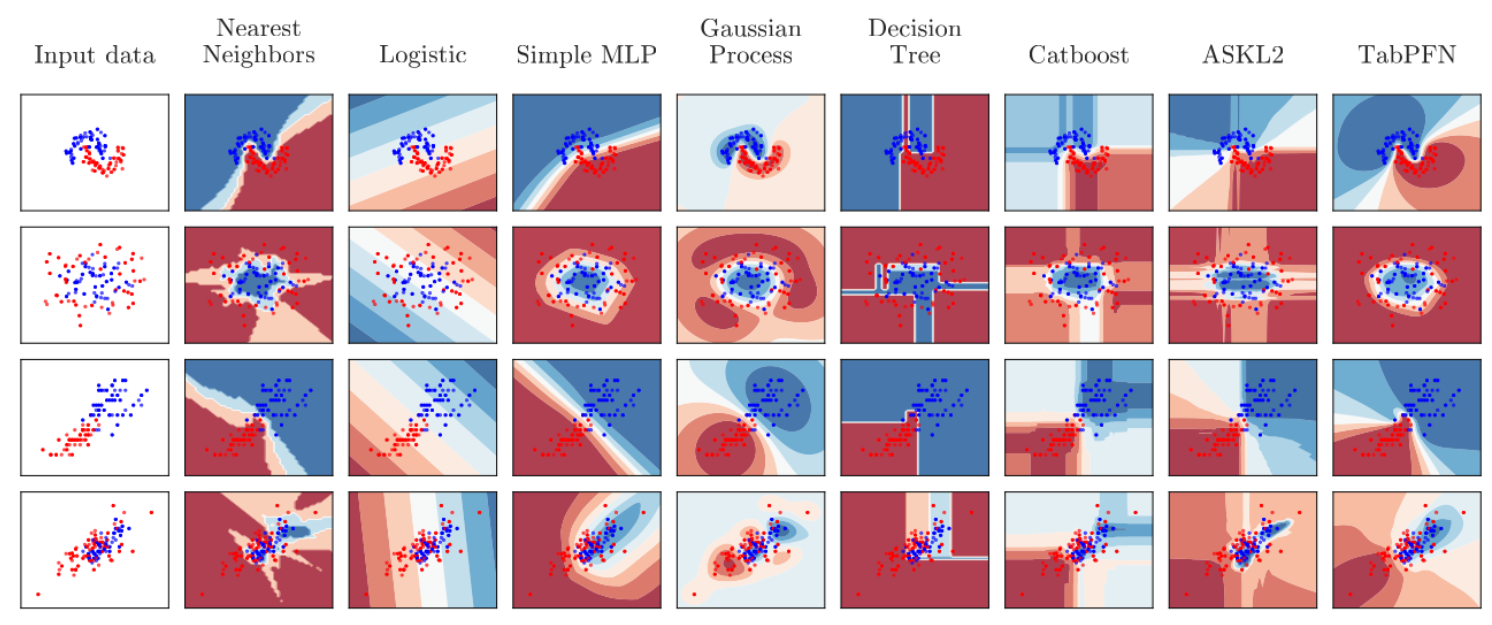

### **TabNet**

TabNet là một mô hình deep learning cho dữ liệu bảng, được giới thiệu trong:

- Sercan Ö. Arik & Tomas Pfister, *"TabNet: Attentive Interpretable Tabular Learning,"* AAAI 2021.

#### Ý tưởng chính
- Sử dụng **sequential attention** để chọn ra đặc trưng quan trọng ở từng bước.
- Kết hợp **feature transformer + attentive transformer** để vừa học representation, vừa giữ khả năng giải thích.
- Có khả năng xử lý dữ liệu bảng trực tiếp mà không cần one-hot encoding toàn bộ.

#### Minh họa

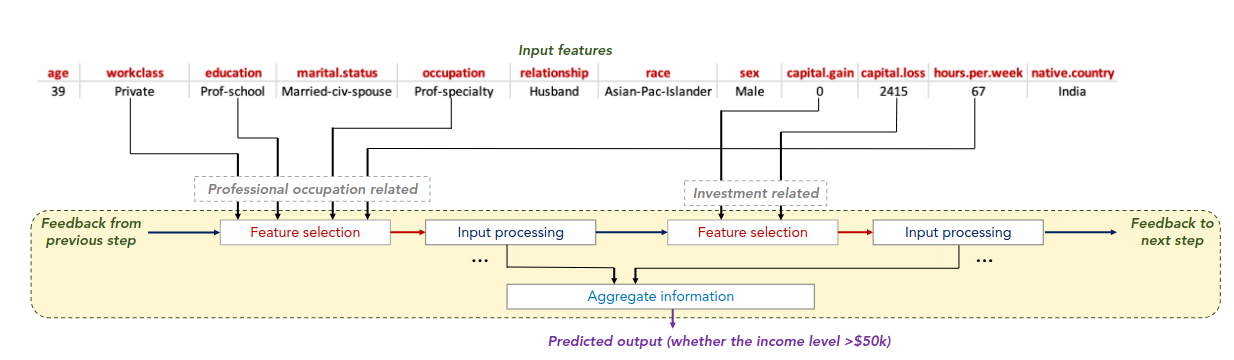

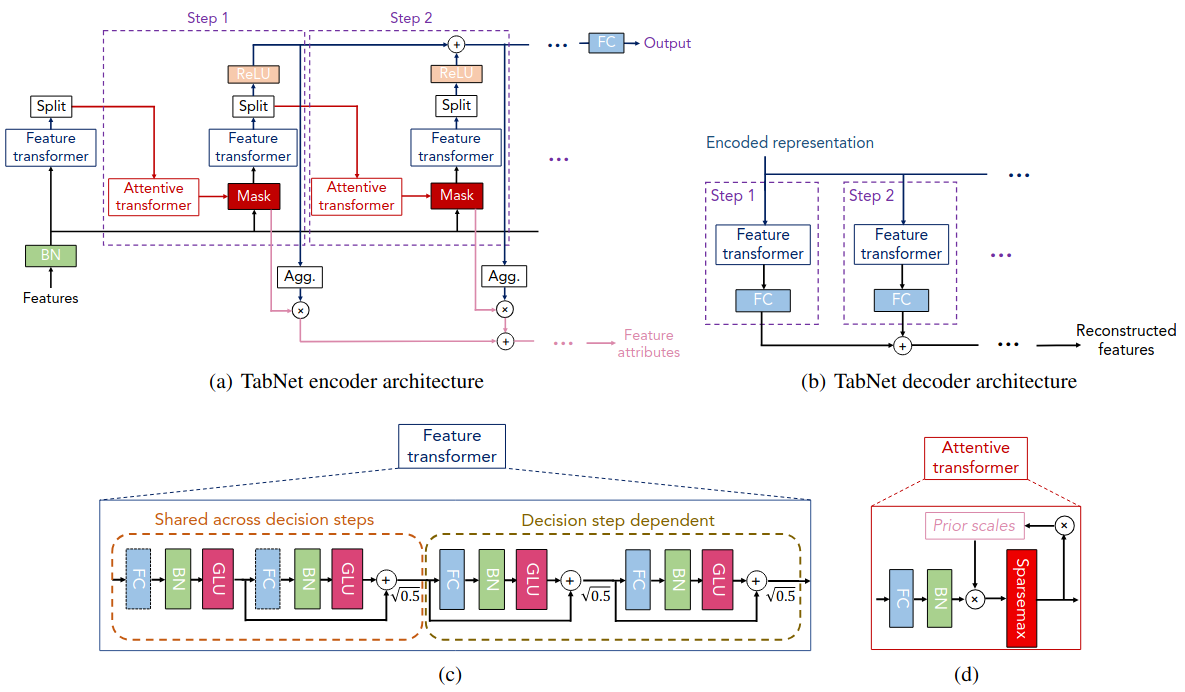



### 3.2. Huấn luyện

In [23]:

numeric_features = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck',"Num","Group"]
categorical_features = ['Member','HomePlanet','CryoSleep','Deck','Side','Destination','VIP']
CONFIG =  {
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "selected_components": {
        # 2 scaler options
        "scaler": [
            "standard_scaler",
            "minmax_01",
            # "minmax_neg11",
            # "minmax_02",
            # "robust" - Took way to long to compute IQR!!!
        ],
        # 3 PCA options
        "pca": [
            "none",
            "pca_0.95",
            "pca_0.98"
        ],
        # 11 model variants
        "model": [
            "logistic",
            "svm_linear",
            "svm_rbf",
            "svm_poly",
            "random_forest",
            "gradient_boosting",
            "decision_tree",
            "xgboost_impute",
            "xgboost_native",
            "TabPFN", # Deep Model
            "TabNet" # Deep Model
        ]
    }

}

In [24]:
configurator = RobustConfigurator(
    X_train, X_test, y_train, y_test,
    CONFIG["numeric_features"],
    CONFIG["categorical_features"],
    experiment_name="btl1"  # This will be used for folder names
)

configurator.generate_experiments(CONFIG["selected_components"])


[INFO] Generated 66 experiments
 - standard_scaler_no_pca_logistic
 - standard_scaler_no_pca_svm_linear
 - standard_scaler_no_pca_svm_rbf
 - standard_scaler_no_pca_svm_poly
 - standard_scaler_no_pca_random_forest
 - standard_scaler_no_pca_gradient_boosting
 - standard_scaler_no_pca_decision_tree
 - standard_scaler_no_pca_xgboost_impute
 - standard_scaler_no_pca_xgboost_native
 - standard_scaler_no_pca_TabPFN
 - standard_scaler_no_pca_TabNet
 - standard_scaler_pca_0.95_logistic
 - standard_scaler_pca_0.95_svm_linear
 - standard_scaler_pca_0.95_svm_rbf
 - standard_scaler_pca_0.95_svm_poly
 - standard_scaler_pca_0.95_random_forest
 - standard_scaler_pca_0.95_gradient_boosting
 - standard_scaler_pca_0.95_decision_tree
 - standard_scaler_pca_0.95_xgboost_impute
 - standard_scaler_pca_0.95_xgboost_native
 - standard_scaler_pca_0.95_TabPFN
 - standard_scaler_pca_0.95_TabNet
 - standard_scaler_pca_0.98_logistic
 - standard_scaler_pca_0.98_svm_linear
 - standard_scaler_pca_0.98_svm_rbf
 - stand

In [25]:
results = configurator.run_experiments(random_state=SEED, save_models=True)
best = configurator.get_best_results(metric="accuracy", top_k=10)
for name, metrics in best:
    print(f"{name}: {metrics['accuracy']:.4f}")
zip_path = configurator.zip_experiment_results()


[INFO] Running 66 experiments...


[INFO] Training:  14%|█▎        | 9/66 [00:15<00:58,  1.03s/it]

tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

[INFO] Training:  15%|█▌        | 10/66 [00:18<01:18,  1.40s/it]

   -> ERROR: Running on CPU with more than 1000 samples is not allowed by default due to slow performance.
To override this behavior, set the environment variable TABPFN_ALLOW_CPU_LARGE_DATASET=1 or set ignore_pretraining_limits=True.
Alternatively, consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client


[INFO] Training:  32%|███▏      | 21/66 [01:17<01:11,  1.59s/it]

   -> ERROR: Running on CPU with more than 1000 samples is not allowed by default due to slow performance.
To override this behavior, set the environment variable TABPFN_ALLOW_CPU_LARGE_DATASET=1 or set ignore_pretraining_limits=True.
Alternatively, consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client


[INFO] Training:  48%|████▊     | 32/66 [02:12<00:58,  1.73s/it]

   -> ERROR: Running on CPU with more than 1000 samples is not allowed by default due to slow performance.
To override this behavior, set the environment variable TABPFN_ALLOW_CPU_LARGE_DATASET=1 or set ignore_pretraining_limits=True.
Alternatively, consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client


[INFO] Training:  65%|██████▌   | 43/66 [02:55<00:25,  1.09s/it]

   -> ERROR: Running on CPU with more than 1000 samples is not allowed by default due to slow performance.
To override this behavior, set the environment variable TABPFN_ALLOW_CPU_LARGE_DATASET=1 or set ignore_pretraining_limits=True.
Alternatively, consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client


[INFO] Training:  65%|██████▌   | 43/66 [02:56<01:34,  4.12s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



Sau khi huấn luyện tất cả các mô hình, chúng ta sẽ trực quan hóa kết quả để so sánh hiệu năng và rút ra kết luận cuối cùng.

### 3.2. Kết Quả

In [ ]:
analyzer = create_professional_analysis("/content/btl1", top_k=15, bottom_k=15)

> 📊 **Nhận xét**
> - `XGBoost` (chuẩn hoá standard scaler với PCA giữ lại 95–98% phương sai, cả bản native và impute) đạt hiệu năng cao nhất với F1 ≈ 0.814, vượt trội hơn hẳn so với các mô hình khác.
>- `TabPFN` và `Random Forest` xếp ngay sau, quanh mức 0.801–0.808, cho thấy khả năng cạnh tranh khá tốt nhưng vẫn kém `XGBoost` khoảng 0.5–1%.
> - `Gradient Boosting` và `TabNet` dao động quanh 0.79–0.80%, hiệu năng thấp hơn nhưng vẫn giữ mức ổn định.
> - `SVM` (`RBF`, `Linear`, `Poly`) và Logistic Regression giảm hiệu năng đáng kể (~0.71–0.79), nhạy cảm rõ rệt với chuẩn hoá và PCA.
> - `Decision Tree` đơn lẻ cho kết quả thấp nhất (~0.68–0.75), kém xa so với ensemble tree-based models.
> - Nhìn chung, chuẩn hoá bằng `Standard Scaler` kết hợp `PCA (95–98%)` giúp ổn định hiệu năng ở các mô hình phức tạp, trong khi các phương pháp không PCA hoặc MinMax scaling dễ làm suy giảm kết quả.
> - **Ensemble tree-based models (XGBoost, Random Forest) tiếp tục là lựa chọn tối ưu và phù hợp nhất cho bộ dữ liệu này.**

🔑 ***Key Insights***

**Best Scaler**: *Standard Scaler*

**Best Model**: *XGBoost* with *Standard Scaler*, *PCA* 98% and using *Impute* to handle missing value